In [ ]:
# default_exp analyse_customers

# Analyse customers

> transactions per user,

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
# export
import logging
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
# hide
logging.basicConfig(level=logging.INFO)

### Compute transactions per user

> number of purchases made by the user, minimum, maximum, average amounts and total amount spent during all the visits

Original section: 4.1.3 Consumer Order Combinations. Original cells: 47-49

In [ ]:
from customer_segmentation_toolkit.load_split import load_data_csv

DATA = '../data/output/03_data_compute_description_keywords'
with open(f'{DATA}/n_purchase_clusters.txt', 'r') as f:
    N_PURCHASE_CLUSTERS = int(f.read())
logging.info(f'N_PURCHASE_CLUSTERS={N_PURCHASE_CLUSTERS}')

basket_price = load_data_csv(f'{DATA}/no_live_data__cleaned__purchase_clusters__train.csv')
basket_price.head()

INFO:root:N_PURCHASE_CLUSTERS=5


,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
0,12347,537626,711.79,293.35,23.40,83.40,124.44,187.2,2010-12-07 14:57:00.000001024
1,12347,542237,475.39,169.20,84.34,53.10,38.25,130.5,2011-01-26 14:29:59.999999744
2,12347,549222,636.25,115.00,81.00,71.10,38.25,330.9,2011-04-07 10:42:59.999999232
3,12347,556201,382.52,168.76,41.40,78.06,19.90,74.4,2011-06-09 13:01:00.000000256
4,12348,539318,892.80,0.00,478.80,0.00,240.00,174.0,2010-12-16 19:09:00.000000000


In [ ]:
# export

def build_transactions_per_user(
    basket_price: pd.DataFrame,
    n_purchase_clusters: int,
) -> pd.DataFrame:

    # nb de visites et stats sur le montant du panier / utilisateurs
    transactions_per_user = basket_price.groupby(by=['CustomerID'])['Basket Price']\
                                        .agg(['count','min','max','mean','sum'])
    for i in range(n_purchase_clusters):
        col = 'categ_{}'.format(i)
        transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])\
                                                        [col].sum() / transactions_per_user['sum']*100
    transactions_per_user.reset_index(drop=False, inplace=True)
    
    last_date = basket_price['InvoiceDate'].max().date()

    first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
    last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

    test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
    test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

    transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
    transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

    return transactions_per_user

In [ ]:
transactions_per_user = build_transactions_per_user(basket_price, n_purchase_clusters=N_PURCHASE_CLUSTERS)
transactions_per_user.head()

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,4,382.52,711.79,551.487500,2205.95,33.831682,10.432693,12.949523,10.011106,32.774995,52,236
1,12348,3,227.44,892.80,495.746667,1487.24,0.000000,45.940131,0.000000,21.516366,32.543503,117,227
2,12350,1,334.40,334.40,334.400000,334.40,0.000000,11.692584,27.900718,11.961722,48.444976,179,179
3,12352,4,144.35,840.30,360.370000,1441.48,5.771846,0.707606,3.683714,78.356966,11.479868,131,165
4,12353,1,89.00,89.00,89.000000,89.00,0.000000,0.000000,19.887640,67.078652,13.033708,73,73


In [ ]:
# export

def compute_n_customers_with_unique_purchase(transactions_per_user: pd.DataFrame):
    return transactions_per_user[transactions_per_user['count'] == 1].shape[0]

In [ ]:
n1 = compute_n_customers_with_unique_purchase(transactions_per_user)
n2 = transactions_per_user.shape[0]
print("nb. de clients avec achat unique: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

nb. de clients avec achat unique: 1358/3143  (43.21%)


### Analyse customers distribution

> PCA over customers

Original section: 4.2 Creation of customers categories. Original cells: 50-53

In [ ]:
# export

def convert_customers_df_to_np(
    transactions_per_user: pd.DataFrame,
    n_purchase_clusters: int,
) -> np.ndarray:
    list_cols = ['count','min','max','mean'] + [f'categ_{i}' for i in range(n_purchase_clusters)]
    matrix = transactions_per_user[list_cols].to_numpy()
    return matrix


def analyse_customers_pca(
    matrix: np.ndarray,
    n_components=None,
) -> pd.DataFrame:
    scaler = StandardScaler()
    scaler.fit(matrix)
    # print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
    scaled_matrix = scaler.transform(matrix)
    
    pca = PCA()
    pca.fit(scaled_matrix)
    #pca_samples = pca.transform(scaled_matrix)
    
    return scaled_matrix, pca

In [ ]:
# export

import matplotlib.pyplot as plt
import seaborn as sns

def plot_customers_pca(matrix: np.ndarray, pca: PCA):
    fig, ax = plt.subplots(figsize=(14, 5))
    sns.set(font_scale=1)
    plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
             label='cumulative explained variance')
    sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
                label='individual explained variance')
    plt.xlim(0, 10)

    ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

    plt.ylabel('Explained variance', fontsize = 14)
    plt.xlabel('Principal components', fontsize = 14)
    plt.legend(loc='best', fontsize = 13);

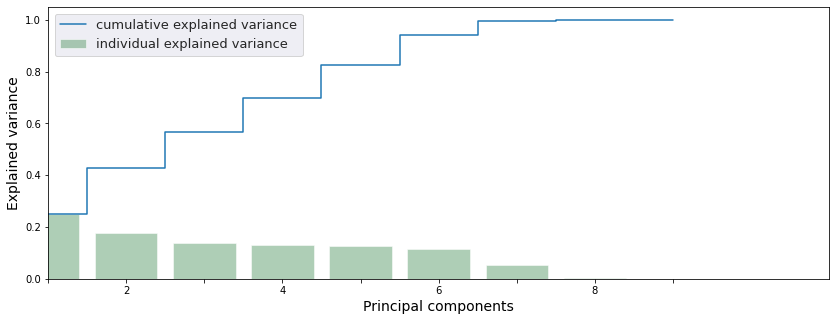

In [ ]:
matrix = convert_customers_df_to_np(transactions_per_user, N_PURCHASE_CLUSTERS)
scaled_matrix, pca = analyse_customers_pca(matrix)
plot_customers_pca(matrix, pca)

### Analyse customers categories

> build customers clusters via Kmeans

Original section: 4.2.2 Creation of customer categories. Original cells: 54-

In [ ]:
# export

def compute_customer_clusters(
    scaled_matrix: np.ndarray,
    n_clusters: int,
) -> np.ndarray:   
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=100)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    return clusters

In [ ]:
N_CUSTOMER_CLUSTERS = 11

clusters_clients = compute_customer_clusters(scaled_matrix, N_CUSTOMER_CLUSTERS)
print(pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T)

silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

                  1    3    8    10   6    2    0    4   9   5   7 
nb. de clients  1174  446  354  279  254  232  205  150  32  10   7
score de silhouette: 0.220


In [ ]:
from customer_segmentation_toolkit.analyse_purchases import plot_silhouette

sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
plot_silhouette(N_CUSTOMER_CLUSTERS, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

ModuleNotFoundError: No module named 'customer_segmentation_toolkit.data'

In [ ]:
# export

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns


def plot_customer_categories(
    scaled_matrix: np.ndarray,
    clusters_clients: np.ndarray,
    n_customer_clusters: int,
):
    mat = pd.DataFrame(scaled_matrix)
    mat['cluster'] = pd.Series(clusters_clients)

    sns.set_style("white")
    sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

    LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                       10:'yellow', 11:'tomato', 12:'seagreen'}
    label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

    fig = plt.figure(figsize = (12,10))
    increment = 0
    for ix in range(6):
        for iy in range(ix+1, 6):   
            increment += 1
            ax = fig.add_subplot(4,3,increment)
            ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
            plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
            plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
            ax.yaxis.grid(color='lightgray', linestyle=':')
            ax.xaxis.grid(color='lightgray', linestyle=':')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

            if increment == 12: break
        if increment == 12: break

    #_______________________________________________
    # I set the legend: abreviation -> airline name
    comp_handler = []
    for i in range(n_customer_clusters):
        comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

    plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
               title='Cluster', facecolor = 'lightgrey',
               shadow = True, frameon = True, framealpha = 1,
               fontsize = 13, bbox_transform = plt.gcf().transFigure)

    plt.tight_layout()


In [ ]:
plot_customer_categories(scaled_matrix, clusters_clients, N_CUSTOMER_CLUSTERS)

Original cells 59-61:

In [ ]:
# export

def add_customer_clusters_info(
    transactions_per_user: pd.DataFrame,
    clusters_clients: np.ndarray,
):
    selected_customers = transactions_per_user.copy(deep = True)
    selected_customers.loc[:, 'cluster'] = clusters_clients
    
    return selected_customers

In [ ]:
selected_customers_df = add_customer_clusters_info(transactions_per_user, clusters_clients)
selected_customers_df

In [ ]:
# export

def compute_aggregated_customer_clusters_info(
    selected_customers: pd.DataFrame,
    n_purchase_clusters: int,
    n_customer_clusters: int,
    categ_threshold: int = 35,
):
    merged_df = pd.DataFrame()
    for i in range(n_customer_clusters):
        test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
        test = test.T.set_index('cluster', drop = True)
        test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
        merged_df = pd.concat([merged_df, test])

    merged_df.drop('CustomerID', axis = 1, inplace = True)
    
    merged_df = merged_df.sort_values('sum')
    
    liste_index = []
    for i in range(n_purchase_clusters):
        column = 'categ_{}'.format(i)
        # XXX: Here we changed the constant: 45 -> categ_threshold
        # Otherwise we get: IndexError: index 0 is out of bounds for axis 0 with size 0
        liste_index.append(merged_df[merged_df[column] > categ_threshold].index.values[0])
    liste_index_reordered = liste_index
    set_index = set(liste_index)
    liste_index_reordered += [ s for s in merged_df.index if s not in set_index]
    merged_df = merged_df.reindex(index = liste_index_reordered)
    merged_df = merged_df.reset_index(drop = False)
    
    return merged_df

In [ ]:
merged_df = compute_aggregated_customer_clusters_info(selected_customers_df, N_PURCHASE_CLUSTERS, N_CUSTOMER_CLUSTERS)
print('number of customers:', merged_df['size'].sum())
merged_df

In [ ]:
# export

# TODO: plot radarchart
# Artem Y: I'm getting a weird error:
#   ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (5).